In [1]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pickle

import torch
import torchvision
import torchvision.transforms as transforms

import pandas as pd

In [14]:
dataset = get_dataset(dataset="poverty", download=True)

In [15]:
# Get the training set
train_data = dataset.get_subset(
    "train",
)

valid_data = dataset.get_subset(
    "val",
)

In [16]:
train_loader = get_train_loader("standard", train_data, batch_size=64)
valid_loader = get_train_loader("standard", valid_data, batch_size=64)

In [17]:
torch.cuda.is_available()

True

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(8, 48, 3)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.conv3 = nn.Conv2d(96, 1, 1)
        
        self.fc1 = nn.Linear(2916, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x, meta):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net2 = Net2()

if torch.cuda.is_available():
    net2 = net2.cuda()

In [19]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [22]:
train_losses = []
valid_losses = []
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    count = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels, meta = data
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        count += 1
    # print statistics
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / count:.3f}')
    train_losses.append(running_loss/float(count))
    
    running_loss = 0.0
    count = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images, labels, meta = data

            # put data onto gpu if available
            if torch.cuda.is_available():
                images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()

            outputs = net2(images, meta)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            count += 1
        # print statistics
        print(f'val loss: {running_loss / count:.3f}')
        valid_losses.append(running_loss/float(count))

print('Finished Training')

[1,   154] loss: 0.235
val loss: 0.176
[2,   154] loss: 0.233
val loss: 0.190
[3,   154] loss: 0.228
val loss: 0.190
[4,   154] loss: 0.226
val loss: 0.189
[5,   154] loss: 0.224
val loss: 0.228
[6,   154] loss: 0.226
val loss: 0.199
[7,   154] loss: 0.220
val loss: 0.180
[8,   154] loss: 0.218
val loss: 0.184
Finished Training


In [ ]:
.177

In [114]:
train_y = np.array([])
train_pred = np.array([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels, meta = data
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
        
        # calculate outputs by running images through the network
        outputs = net2(images, meta)
        
        train_y = np.append(train_y, labels.cpu())
        train_pred = np.append(train_pred, outputs.data.cpu())

In [115]:
train_y.min()

-1.229017734527588

In [143]:
train_pred.min()

-0.5069403648376465

In [ ]:
(((train_y - train_pred)**2).mean()-train_y.var())/train_y.var()

In [151]:
train_y.var()

0.6560673337806222

In [23]:
valid_y = np.array([])
valid_pred = np.array([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels, meta = data
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
        
        # calculate outputs by running images through the network
        outputs = net2(images, meta)
        
        valid_y = np.append(valid_y, labels.cpu())
        valid_pred = np.append(valid_pred, outputs.data.cpu())

In [24]:
((valid_y - valid_pred)**2).mean()

0.18637400729218512

In [25]:
valid_y.var()

0.47868604767503037

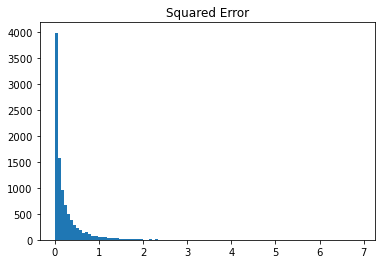

In [118]:
plt.hist((train_y - train_pred)**2, bins=100)
plt.title("Squared Error")
plt.show()

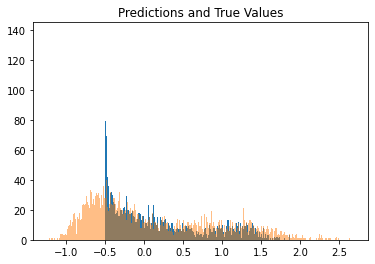

In [137]:
plt.hist(train_pred, bins=1000)
plt.hist(train_y, bins=1000, alpha=0.5)
plt.title("Predictions and True Values")
plt.show()

In [147]:
net2.cpu()(dataset[123][0][None], dataset[123][2][None])[0][0].item()

-0.47906115651130676

In [144]:
for p in range(1000):
    if net2.cpu()(dataset[p][0][None], dataset[p][2][None])[0][0].item() <= -0.5:
        print(p)

57
75
77
121
122
126
127
130
131
133
152
160
164
175
176
233
234
236
238
239
244
260
261
263
453
509
564
627
664
742
766
770
774
777
778
794
819
824
825
845
851
852


In [99]:
_y = np.array([])
_y_pred = np.array([])


with torch.no_grad():
    for i in range(100):
        _y = np.append(_y, dataset[i][1])
        _y_pred = np.append(_y_pred, net2.cpu()(dataset[i][0][None], dataset[i][2][None]))
        

In [100]:
_y

array([-1.0193609 , -1.09005249, -1.14300203,  1.05676901,  1.45406449,
        1.70844567,  1.70110953,  1.54771316,  1.59246266,  1.70628917,
        1.29460955,  0.99117357,  1.16622615, -0.95553303,  1.47247434,
        1.24541461,  2.23700643,  1.47427261,  0.98741227,  0.15869898,
       -0.94360435, -1.14929593,  1.03297925,  1.30253994, -0.93413574,
        0.0344386 , -0.62296993,  1.00921047,  1.38325882, -1.14463282,
        0.21154982, -1.16648209, -1.258183  , -1.11952424, -1.19205213,
       -0.8104406 ,  1.15505421,  1.42686856, -0.66122097, -0.73772377,
        1.13657022,  1.86424863,  1.72541571,  1.33544159,  1.54196131,
        1.81660414,  0.40904918,  1.6719749 ,  1.57822442,  2.11094522,
        0.8000375 , -1.03021395, -0.84018356,  2.59561753, -0.07346991,
        0.72167271,  0.90646887, -0.80004483,  1.87934387,  1.74931741,
        1.1053592 , -0.46350324, -1.0571233 , -0.11726858,  0.38161853,
        2.20962048,  0.18236142,  0.69121599, -0.48142657, -0.90

In [101]:
_y_pred

array([ 0.12386689, -0.01421173, -0.26011232,  2.17806935,  1.83364081,
        1.978652  ,  1.54503107,  2.0808382 ,  2.07136512,  2.05816293,
        1.66236806,  1.7560389 ,  1.74165416, -0.49958509,  1.75715947,
        1.65146828,  1.75538445,  1.65080404,  1.40482783,  1.23084283,
        0.78295308,  0.5228374 ,  1.29689527,  1.31361127, -0.23893569,
        0.54510623,  0.48568034,  1.58184695,  1.53843951,  0.3105191 ,
        0.99160308,  0.16765332,  0.31108934, -0.21940491, -0.37049827,
       -0.27947009,  0.67612225,  0.81310302,  0.34858346,  0.27456826,
        1.59495139,  1.64246941,  1.62192345,  1.64906216,  1.64195728,
        1.645854  , -0.48835504,  1.61743593,  1.59510875,  1.43196917,
        0.98061961,  1.22323132,  0.27529556,  1.25869775,  0.73711681,
        0.45548028,  1.4422245 , -0.50514233,  1.59906197,  1.6144073 ,
        1.54264927,  0.70377523,  0.39669913,  1.50034714,  1.46232033,
        1.6345377 ,  1.10150099,  1.06017041,  0.00859566,  0.18

In [103]:
((_y - _y_pred)**2).mean()

0.7026532683053631

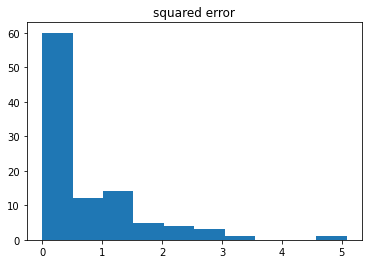

In [107]:
plt.hist((_y - _y_pred)**2)
plt.title('squared error')
plt.show()

(array([22.,  5.,  8., 10.,  6.,  7.,  9., 16., 12.,  5.]),
 array([-0.50514233, -0.23682116,  0.03150001,  0.29982117,  0.56814234,
         0.83646351,  1.10478468,  1.37310585,  1.64142702,  1.90974818,
         2.17806935]),
 <BarContainer object of 10 artists>)

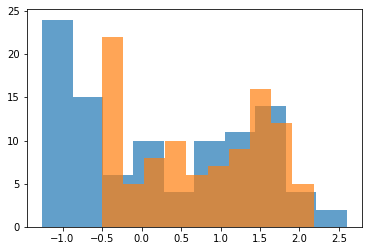

In [109]:
plt.hist(_y, label='y', alpha=0.7)
plt.hist(_y_pred, label='pred', alpha=0.7)
plt.

In [150]:
#explore different loss functions
# classify between 40th and 60th percentiles

Net2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(8, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(96, 1, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=2916, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [153]:
val_data = dataset.get_subset(
    "val",
)

In [154]:
val_loader = get_train_loader("standard", val_data, batch_size=64)

In [159]:
val_y = np.array([])
val_pred = np.array([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        images, labels, meta = data
        
        # put data onto gpu if available
        if torch.cuda.is_available():
            images, labels, meta = images.cuda(), labels.cuda(), meta.cuda()
        
        # calculate outputs by running images through the network
        outputs = net2(images, meta)
        
        val_y = np.append(val_y, labels.cpu())
        val_pred = np.append(val_pred, outputs.data.cpu())

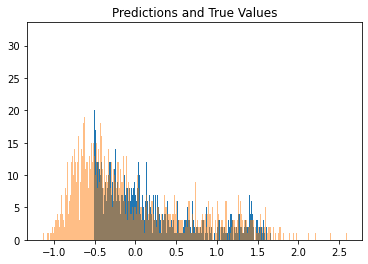

In [160]:
plt.hist(val_pred, bins=1000)
plt.hist(val_y, bins=1000, alpha=0.5)
plt.title("Predictions and True Values")
plt.show()

In [161]:
((val_y - val_pred)**2).mean()

0.2370367279781401

In [162]:
val_y.var()

0.47868604767503037